### The current notebook uses the electric-motor-temperature dataset to predict the rotor temperature of a motor.

The dataset and its description is available here:
https://www.kaggle.com/wkirgsn/electric-motor-temperature


The goal of the project is to efficietly predict the rotor temperature of a permanent magnet synchronous motor (PMSM), as it is usually difficult to measure the rotor temperature. This kind of prediction helps to reduce the amount of equipment that is to be mounted on to the motor to measure the temperature.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.preprocessing import MinMaxScaler

torch.manual_seed(2)
np.random.seed(2)

In [2]:
df = pd.read_csv("pmsm_temperature_data.csv")

In [3]:
df.head()

,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm,stator_yoke,stator_tooth,stator_winding,profile_id
0,-0.752143,-1.118446,0.327935,-1.297858,-1.222428,-0.250182,1.029572,-0.245860,-2.522071,-1.831422,-2.066143,-2.018033,4
1,-0.771263,-1.117021,0.329665,-1.297686,-1.222429,-0.249133,1.029509,-0.245832,-2.522418,-1.830969,-2.064859,-2.017631,4
2,-0.782892,-1.116681,0.332771,-1.301822,-1.222428,-0.249431,1.029448,-0.245818,-2.522673,-1.830400,-2.064073,-2.017343,4
3,-0.780935,-1.116764,0.333700,-1.301852,-1.222430,-0.248636,1.032845,-0.246955,-2.521639,-1.830333,-2.063137,-2.017632,4
4,-0.774043,-1.116775,0.335206,-1.303118,-1.222429,-0.248701,1.031807,-0.246610,-2.521900,-1.830498,-2.062795,-2.018145,4


##### As explained in the description the profile_id column in the data set corresponds to different measurement sessions. The most interesting target features given in description are rotor temperature('pm), stator temperatures('stator_*) and torque. 
##### All the other features are considered to be inputs features

In [4]:
col_list = df.columns.tolist()
profile_id = ['profile_id']
target_list = ['pm', 'torque', 'stator_yoke', 'stator_tooth', 'stator_winding']
feature_list = [col for col in col_list if col not in target_list and col not in profile_id]

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 998070 entries, 0 to 998069
Data columns (total 13 columns):
ambient           998070 non-null float64
coolant           998070 non-null float64
u_d               998070 non-null float64
u_q               998070 non-null float64
motor_speed       998070 non-null float64
torque            998070 non-null float64
i_d               998070 non-null float64
i_q               998070 non-null float64
pm                998070 non-null float64
stator_yoke       998070 non-null float64
stator_tooth      998070 non-null float64
stator_winding    998070 non-null float64
profile_id        998070 non-null int64
dtypes: float64(12), int64(1)
memory usage: 99.0 MB


##### As profile id just indicates which measurement session the data belongs to, it can be treated as categorical variable, and also to make select data that is relevant to the session

In [6]:
df['profile_id'] = df.profile_id.astype('category', inplace=True)
df.profile_id.unique()

[4, 6, 10, 11, 20, ..., 78, 79, 80, 81, 72]
Length: 52
Categories (52, int64): [4, 6, 10, 11, ..., 79, 80, 81, 72]

### Since all the variables/features are measured over time and are time dependant. The later analysis is done assuming the data to be time series data.

#### For this reason, the data is split into number of time sequences. The target value for a given sequence will be the value which is just after a given sequence.

In [7]:
def build_sequences(features_df, target_df, sequence_length = 10):
    """Builds sequences from data and converts them into pytorch tensors
        sequence_length - represents the number of samples to be considered in a sequence
    """
    data_ = []
    target_ = []
    
    for i in range(int(features_df.shape[0]/sequence_length)):
        
        data = torch.from_numpy(features_df.iloc[i:i+sequence_length].values)
        target = torch.from_numpy(target_df.iloc[i+sequence_length+1].values)
        
        data_.append(data)
        target_.append(target)
        
    data = torch.stack(data_)
    target = torch.stack(target_)
    
    return data, target

In [8]:
prof_ids = list(df.profile_id.unique())
print(prof_ids)

[4, 6, 10, 11, 20, 27, 29, 30, 31, 32, 36, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 73, 74, 75, 76, 77, 78, 79, 80, 81, 72]


###### Slecting a measurement profile to prepare the data

In [9]:
# idx = np.random.randint(len(prof_ids)))

# prof_id = prof_ids[idx]
# print('Selected profile -',prof_id)

### OR ###
prof_id = 6

curr_df = df[df['profile_id'] == prof_id]

curr_df = curr_df.drop('profile_id', axis = 1)
columns = curr_df.columns.tolist()

In [10]:
scaler = MinMaxScaler()

curr_df = pd.DataFrame(scaler.fit_transform(curr_df), columns= columns)
curr_df.head()

,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm,stator_yoke,stator_tooth,stator_winding
0,0.422350,0.064550,0.495541,0.173390,0.000066,0.605967,0.957416,0.635014,0.000142,0.000600,0.000105,0.000711
1,0.424296,0.064815,0.495157,0.174028,0.000064,0.610011,0.955582,0.640728,0.000089,0.000826,0.000087,0.000582
2,0.425627,0.064977,0.494894,0.174470,0.000063,0.612710,0.954268,0.644823,0.000089,0.000758,0.000058,0.000427
3,0.426669,0.065209,0.494701,0.174815,0.000062,0.614798,0.953327,0.647756,0.000003,0.000342,0.000021,0.000326
4,0.427242,0.065387,0.494559,0.175044,0.000060,0.616119,0.952652,0.649859,0.000000,0.000086,0.000013,0.000273


### Sequence length has to be selected prior to the model initialization

##### As the sampling is done at 2 Hz, the sequence size can be >= 2. But, keeping in view the importance of speed of operation as the values are needed for other operations or control, it should be as small as possible to reduce the delay.

##### Also, another point to be noted here is, if the sequence length is higher the prediction error is less. So there must be a trade off between the required error rate and speed (in this case the initial prediction). 

##### The delay in responce will be only at the beginning and the later predictions will not have the delay if real time operation is considered.

In [11]:
sequence_length = 3

features = curr_df[feature_list]
target = curr_df[target_list][['pm']]

data, target = build_sequences(features, target, sequence_length=sequence_length)

##### Dividing the generated sequences into training and testing set

In [12]:
# Test size the percentage of data to be used for testing
test_size = 0.05

indices = torch.randperm(data.shape[0])

train_indices = indices[:int(indices.shape[0] * (1-test_size))]
test_indices = indices[int(indices.shape[0] * (1-test_size)):]

X_train, y_train = data[train_indices], target[train_indices]
X_test, y_test = data[test_indices], target[test_indices]

##### A Dataset class is needed for the data inorder to use the dataloader of Pytorch

In [13]:
class PMSMDataset(torch.utils.data.dataset.Dataset):
    """Dataset with Rotor Temperature as Target"""
    def __init__(self, data, target):
        
        self.data = data
        self.target = target
        
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        return self.data[idx].unsqueeze(0), self.target[idx]

In [14]:
batch_size = 10

pm_train_dataset = PMSMDataset(X_train, y_train)
pm_train_loader = torch.utils.data.dataloader.DataLoader(pm_train_dataset, batch_size= batch_size)

pm_test_dataset = PMSMDataset(X_test, y_test)
pm_test_loader = torch.utils.data.dataloader.DataLoader(pm_test_dataset, batch_size= 1)

##### The network class

In [15]:
class Network(nn.Module):
    def __init__(self, sequence_length, n_features):
        super(Network, self).__init__()
        
        
        self.conv1 = nn.Conv1d(1, 3, kernel_size=(sequence_length, n_features))
        
        self.lin_in_size = self.conv1.out_channels * int(((sequence_length - (self.conv1.kernel_size[0]-1) -1)/self.conv1.stride[0] +1))
        
        print(self.lin_in_size)
        
        self.fc1 = nn.Linear(self.lin_in_size,30)
        self.fc2 = nn.Linear(30, 1)
        
    def forward(self, x):
        
        x = F.relu(self.conv1(x))
        x = x.view(-1, self.lin_in_size)
        
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

##### Note that the same sequence length used to generate the data should be used to create the network

In [16]:
n_features = X_train.shape[-1]

net = Network(sequence_length, n_features).double()
net

3


Network(
  (conv1): Conv1d(1, 3, kernel_size=(3, 7), stride=(1,))
  (fc1): Linear(in_features=3, out_features=30, bias=True)
  (fc2): Linear(in_features=30, out_features=1, bias=True)
)

In [17]:
lr = 0.001

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=lr)

### Training

In [18]:
training_losses = []
for epoch in range(50):
    running_loss = 0.0
    batch_losses = []
    for i, (data, target) in enumerate(pm_train_loader):

        optimizer.zero_grad()

        out = net(data)

        loss = criterion(out, target)
        batch_losses.append(loss.item())

        loss.backward()
        optimizer.step()            
    training_losses.append(np.mean(batch_losses))
    print("Epoch {}, loss {:.6f}".format(epoch+1, training_losses[-1]))

Epoch 1, loss 0.022153
Epoch 2, loss 0.011547
Epoch 3, loss 0.010910
Epoch 4, loss 0.010277
Epoch 5, loss 0.009511
Epoch 6, loss 0.008837
Epoch 7, loss 0.008203
Epoch 8, loss 0.007525
Epoch 9, loss 0.006794
Epoch 10, loss 0.005930
Epoch 11, loss 0.004891
Epoch 12, loss 0.003675
Epoch 13, loss 0.002361
Epoch 14, loss 0.001269
Epoch 15, loss 0.000770
Epoch 16, loss 0.000637
Epoch 17, loss 0.000615
Epoch 18, loss 0.000603
Epoch 19, loss 0.000601
Epoch 20, loss 0.000595
Epoch 21, loss 0.000592
Epoch 22, loss 0.000588
Epoch 23, loss 0.000584
Epoch 24, loss 0.000581
Epoch 25, loss 0.000579
Epoch 26, loss 0.000577
Epoch 27, loss 0.000574
Epoch 28, loss 0.000572
Epoch 29, loss 0.000570
Epoch 30, loss 0.000568
Epoch 31, loss 0.000566
Epoch 32, loss 0.000565
Epoch 33, loss 0.000563
Epoch 34, loss 0.000562
Epoch 35, loss 0.000561
Epoch 36, loss 0.000560
Epoch 37, loss 0.000558
Epoch 38, loss 0.000557
Epoch 39, loss 0.000556
Epoch 40, loss 0.000555
Epoch 41, loss 0.000554
Epoch 42, loss 0.000553
E

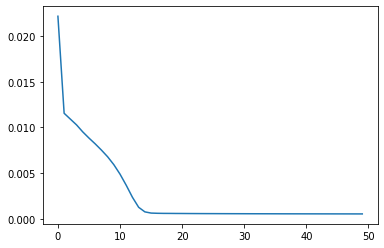

In [19]:
plt.plot(training_losses)

### Testing

In [20]:
losses = []
batch_losses = []
targets = []
outputs = []
with torch.no_grad():
    for i, (data, target) in enumerate(pm_test_loader):
        out = net(data)
        loss = criterion(out, target)
#         print('Target : {:.4f}, Predicted Output : {:.4f}'.format(target.item(), out.item()))
        
        targets.append(target.item())
        outputs.append(out.item())
        
        batch_losses.append(loss.item())
    losses.append(np.mean(batch_losses))
print("Testing loss {:.6f}".format(losses[-1]))

Testing loss 0.000434


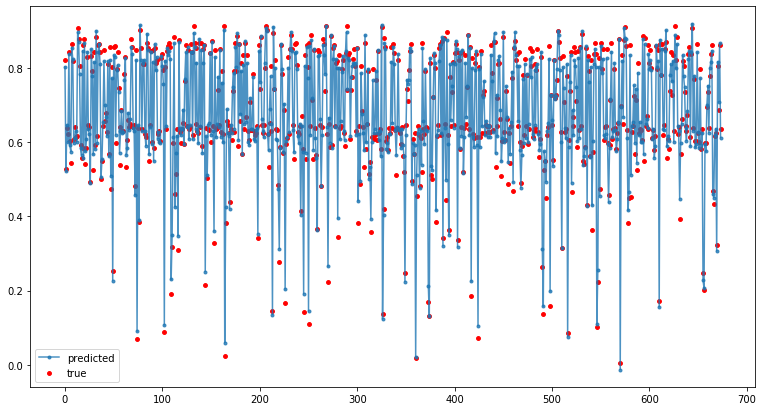

In [21]:
plt.figure(figsize=(13,7))
# plt.scatter(np.arange(len(outputs)),outputs, c = 'b', s = 15, marker='*', label = 'predicted')
plt.plot(np.arange(len(outputs)),outputs, alpha = 0.8, marker = '.',label = 'predicted' )
plt.scatter(np.arange(len(targets)),targets, c = 'r', s = 15, label = 'true')
plt.legend(loc='best')